In [593]:
import warnings
warnings.filterwarnings("ignore")

In [594]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [595]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

In [596]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Business Objective

In [597]:
df_hourly = pd.read_csv('Fremont_Bridge_Bicycle_Counter.csv',index_col= 'Date', parse_dates=True)
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64944 entries, 2012-10-03 00:00:00 to 2020-02-29 23:00:00
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Fremont Bridge Total          64934 non-null  float64
 1   Fremont Bridge East Sidewalk  64934 non-null  float64
 2   Fremont Bridge West Sidewalk  64934 non-null  float64
dtypes: float64(3)
memory usage: 2.0 MB


In [598]:
df_hourly.shape

(64944, 3)

In [599]:
df_hourly.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0
2012-10-03 04:00:00,7.0,6.0,1.0


# Data Preprocessing

In [600]:
df_hourly.rename(columns={'Fremont Bridge East Sidewalk': 'east_sidewalk'}, inplace=True)
df_hourly.rename(columns={'Fremont Bridge West Sidewalk': 'west_sidewalk'}, inplace=True)
df_hourly.rename(columns={'Fremont Bridge Total': 'Total'}, inplace=True)

In [601]:
df_hourly.head()

,Total,east_sidewalk,west_sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0
2012-10-03 04:00:00,7.0,6.0,1.0


In [602]:
df_hourly.isnull().sum() #Null values detected

Total            10
east_sidewalk    10
west_sidewalk    10
dtype: int64

In [603]:
df_hourly = df_hourly.fillna(method='ffill') #Replacing null values with forward fill

In [604]:
df_hourly.isnull().sum()

Total            0
east_sidewalk    0
west_sidewalk    0
dtype: int64

In [605]:
df = df_hourly.resample('D').sum()
df.head()

,Total,east_sidewalk,west_sidewalk
Date,,,
2012-10-03,3521.0,1760.0,1761.0
2012-10-04,3475.0,1708.0,1767.0
2012-10-05,3148.0,1558.0,1590.0
2012-10-06,2006.0,1080.0,926.0
2012-10-07,2142.0,1191.0,951.0


In [606]:
df.shape

(2706, 3)

In [607]:
df['Date'] = df.index.date
df['Date']=  pd.to_datetime(df['Date'],format="%Y-%m-%d") 

In [608]:
df['day_of_week'] = df['Date'].dt.day_of_week.astype(int)      #Extracting day of week with Monday as 0

In [609]:
df.drop(columns=['Date'], inplace=True)

In [610]:
df.head()

,Total,east_sidewalk,west_sidewalk,day_of_week
Date,,,,
2012-10-03,3521.0,1760.0,1761.0,2
2012-10-04,3475.0,1708.0,1767.0,3
2012-10-05,3148.0,1558.0,1590.0,4
2012-10-06,2006.0,1080.0,926.0,5
2012-10-07,2142.0,1191.0,951.0,6


# EDA

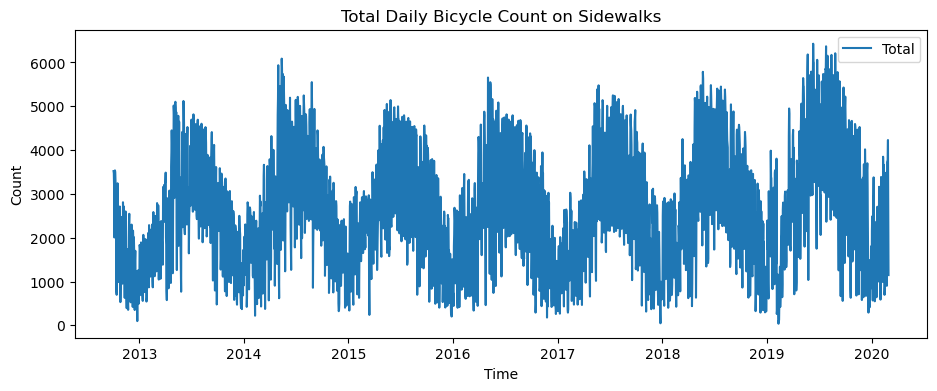

In [611]:
plt.figure(figsize=(11, 4))

# Plot the data
plt.plot(df['Total'], label='Total',)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Total Daily Bicycle Count on Sidewalks')
plt.legend()

# Show the plot
plt.show()

In [612]:
df_hourly.groupby(df_hourly.index.hour).mean()

,Total,east_sidewalk,west_sidewalk
Date,,,
0,11.589800,4.917591,6.672210
1,6.145602,2.753141,3.392461
2,4.025868,1.934220,2.091648
3,2.964523,1.529564,1.434959
4,6.603104,3.498152,3.104952
5,25.963045,15.961936,10.001109
6,91.698078,55.394678,36.303400
7,232.472284,144.875462,87.596822
8,330.886548,195.715447,135.171101


In [613]:
#7AM - 11AM are the peak hours in the morning
#4PM - 8PM are the peark hours in the evening 
#1AM - 4AM in the night are the least active hours

In [614]:
df_monthly = df.resample('M').sum()
df_monthly.drop(columns=['day_of_week'], inplace=True)
df_monthly.groupby(df_monthly.index.month).mean()

,Total,east_sidewalk,west_sidewalk
Date,,,
1,57173.125000,26321.500000,30851.625000
2,52165.750000,23789.250000,28376.500000
3,70291.285714,32611.142857,37680.142857
4,81816.142857,38620.857143,43195.285714
5,116739.571429,54875.857143,61863.714286
6,112212.428571,51597.857143,60614.571429
7,120248.857143,54789.857143,65459.000000
8,115311.571429,51183.714286,64127.857143
9,95499.714286,43144.857143,52354.857143


In [615]:
#Summer is the most active season (May-Sept)
#Winter is off season

In [616]:
df.describe()

,Total,east_sidewalk,west_sidewalk,day_of_week
count,2706.000000,2706.000000,2706.000000,2706.000000
mean,2731.181079,1247.406874,1483.774205,3.000739
std,1366.460922,601.438679,821.046082,1.999445
min,38.000000,19.000000,12.000000,0.000000
25%,1766.250000,815.250000,878.250000,1.000000
50%,2574.000000,1192.000000,1351.500000,3.000000
75%,3790.750000,1692.750000,2088.000000,5.000000
max,6428.000000,3143.000000,4050.000000,6.000000


In [617]:
#Daily Average number of bicycle riders = 2731
#Daily Average number of bicycle riders on east_sidewalk = 1247
#Daily Average number of bicycle riders on west_sidewalk = 1483

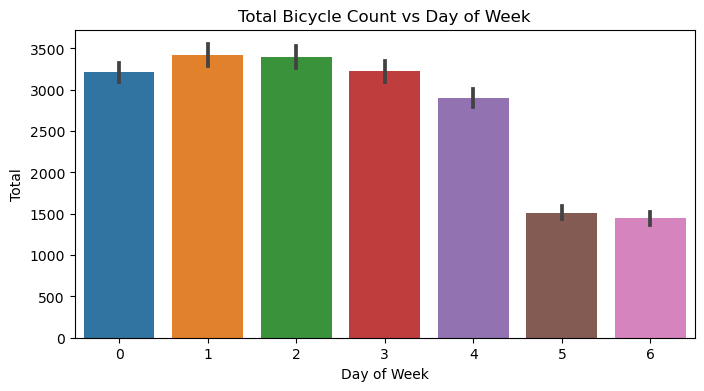

In [618]:
plt.figure(figsize=(8, 4))
sns.barplot(x='day_of_week', y='Total', data=df)
plt.xlabel('Day of Week')
plt.ylabel('Total')
plt.title('Total Bicycle Count vs Day of Week')
plt.show()

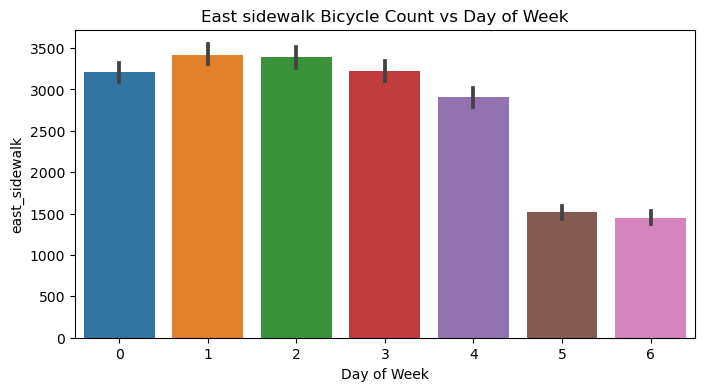

In [619]:
plt.figure(figsize=(8, 4))
sns.barplot(x='day_of_week', y='Total', data=df)
plt.xlabel('Day of Week')
plt.ylabel('east_sidewalk')
plt.title('East sidewalk Bicycle Count vs Day of Week')
plt.show()

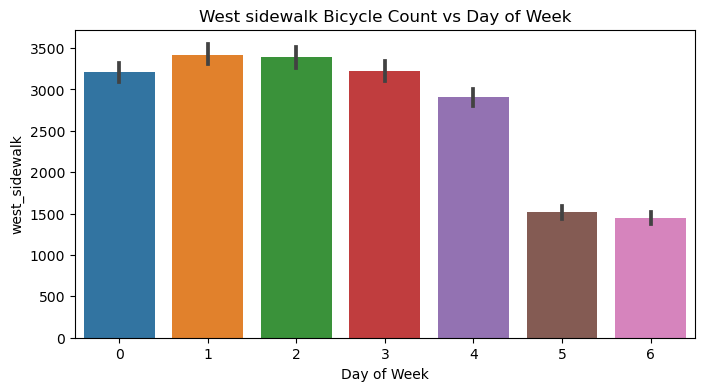

In [620]:
plt.figure(figsize=(8, 4))
sns.barplot(x='day_of_week', y='Total', data=df)
plt.xlabel('Day of Week')
plt.ylabel('west_sidewalk')
plt.title('West sidewalk Bicycle Count vs Day of Week')
plt.show()

In [621]:
#Average number of bicycle riders are less during weekends (Saturday & Sunday)
#Riders are more active during weekdays 
#Tuesday and Wednesday are the busiest days

In [622]:
df = df.resample('W').sum()     #Trainsforming data to weekly
df.shape

(387, 4)

In [623]:
df.drop(columns=['day_of_week'], inplace=True)

In [624]:
df.describe()

,Total,east_sidewalk,west_sidewalk
count,387.000000,387.000000,387.000000
mean,19097.095607,8722.178295,10374.917313
std,6702.658875,3071.102506,4026.616862
min,3379.000000,1271.000000,2108.000000
25%,14051.000000,6256.500000,7282.500000
50%,18571.000000,8543.000000,9935.000000
75%,24791.500000,11498.500000,13052.000000
max,35684.000000,16847.000000,21964.000000


In [625]:
#Weekly Average number of bicycle riders = 19097
#Weekly Average number of bicycle riders on east_sidewalk = 8722
#Weekly Average number of bicycle riders on west_sidewalk = 10374

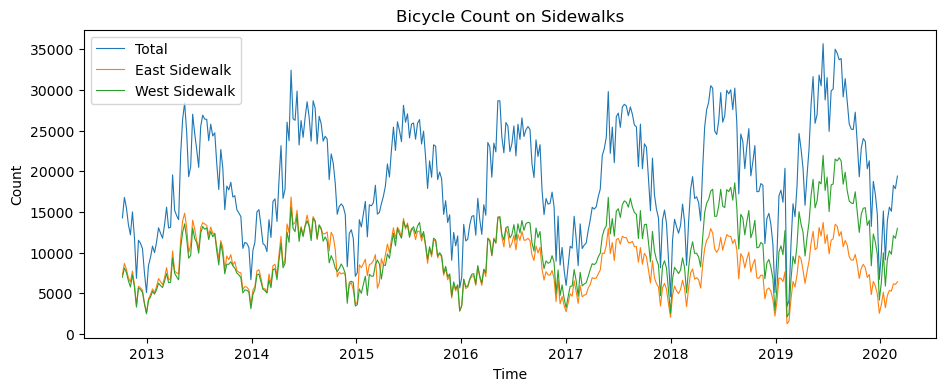

In [369]:
plt.figure(figsize=(11, 4))

# Plot the data
plt.plot(df['Total'], label='Total',linewidth=0.8, linestyle='-')
plt.plot(df['east_sidewalk'], label='East Sidewalk',linewidth=0.8, fillstyle='none')
plt.plot(df['west_sidewalk'], label='West Sidewalk',linewidth=0.8, fillstyle='none')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Bicycle Count on Sidewalks')
plt.legend()

# Show the plot
plt.show()

In [ ]:
#Gap between east sidewalk and west sidewalk has been increasing since early 2017

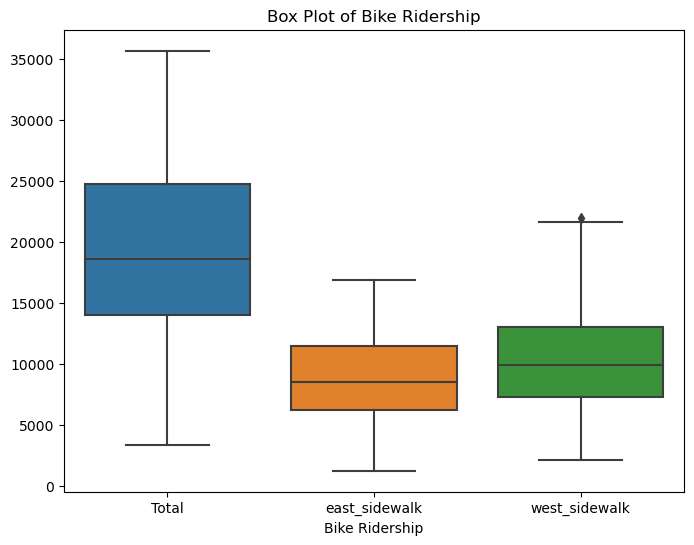

In [370]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df)
plt.xlabel('Bike Ridership')
plt.title('Box Plot of Bike Ridership')
plt.show()

In [365]:
df.head()  

,Total,east_sidewalk,west_sidewalk,day_of_week
Date,,,,
2012-10-07,14292.0,7297.0,6995.0,480
2012-10-14,16795.0,8679.0,8116.0,504
2012-10-21,15509.0,7946.0,7563.0,504
2012-10-28,13437.0,6901.0,6536.0,504
2012-11-04,12194.0,6408.0,5786.0,504


# Test for Seasonality

#### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. These plots help to identify the presence of seasonal patterns in the data. 

The ACF plot shows the correlation between a time series and its lagged values (i.e., correlations with itself over time). In the context of seasonality, a significant spike or peak in the ACF plot at a specific lag indicates a repeating pattern at that lag. This repeating pattern corresponds to the seasonal component of the time series.

The PACF plot shows the partial correlation between a time series and its lagged values after removing the effects of earlier lags. In the context of seasonality, a significant spike or peak in the PACF plot at a specific lag indicates a repeating pattern at that lag that is not accounted for by earlier lags.

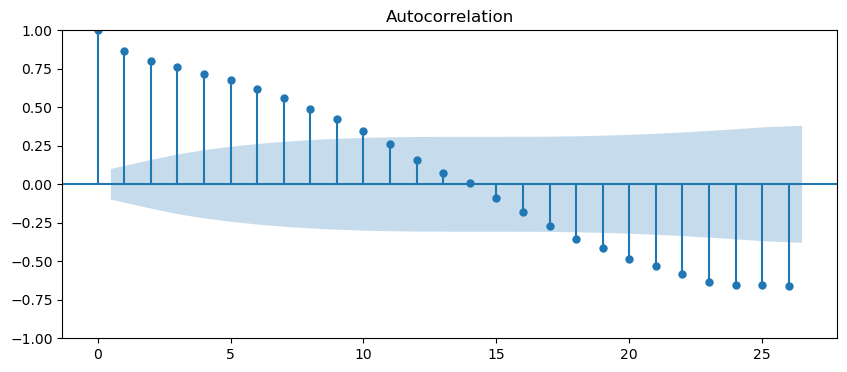

In [93]:
fig, ax = plt.subplots(figsize=(10,4))
plot_acf(df['Total'], ax=ax)
plt.show()

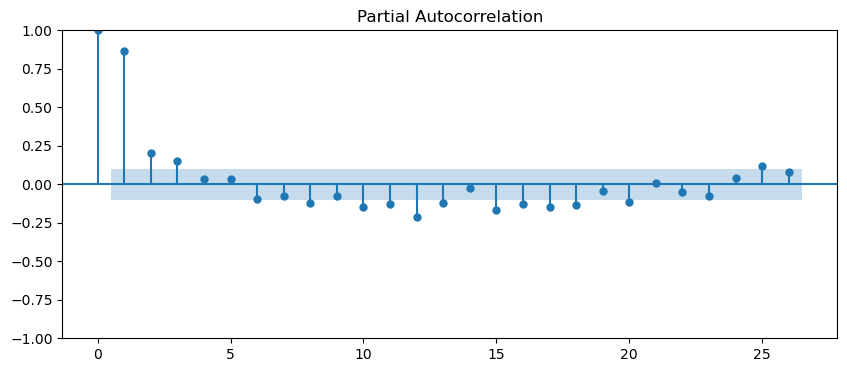

In [95]:
fig, ax = plt.subplots(figsize=(10,4))
plot_pacf(df['Total'], ax=ax)
plt.show()

In [ ]:
#There is seasonality as indicated by ACF and PACF plots

# Test for Stationarity 

The adfuller function returns a tuple containing several values. Below is the description of each value:

ADF Statistic: This is the test statistic of the Augmented Dickey-Fuller test. It is a negative number and is used to assess the stationarity of the time series. The more negative the statistic, the stronger the evidence against the null hypothesis of non-stationarity.

p-value: This is the p-value associated with the null hypothesis of non-stationarity. It represents the probability of observing the ADF statistic or a more extreme value under the assumption that the time series is non-stationary. A smaller p-value indicates stronger evidence against the null hypothesis and suggests stationarity.

In [39]:
res = adfuller(df['Total'])
print('t-value: ', res[0])
print('p-value: ', res[1])

t-value:  -8.489764059646545
p-value:  1.3231663017979682e-13


# Base Model

In [372]:
train = df.Total[:345]
test = df.Total[345:]
train.shape, test.shape

((345,), (42,))

In [373]:
model = SARIMAX(train, order=(1,0,1), seasonal_order=(1,0,1,52), trend='c', )
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Total   No. Observations:                  345
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood               -3265.501
Date:                            Wed, 19 Jul 2023   AIC                           6543.002
Time:                                    21:31:00   BIC                           6566.063
Sample:                                10-07-2012   HQIC                          6552.186
                                     - 05-12-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1996.1687    738.607      2.703      0.007     548.527    3443.811
ar.L1          0.8082      0.051     15.816      0.000       0.708       0.908
ma.L1         -0.2424      0.079     -3.076      0.002      -0.397      -0.088
ar.S.L52       0.4621      0.166      2.782      0.005       0.137       0.788
ma.S.L52      -0.1139      0.194     -0.586      0.558      -0.495       0.267
sigma2      1.056e+07      0.304   3.47e+07      0.000    1.06e+07    1.06e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                41.91
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                            -0.21
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.66e+22. Standard errors may be unstable.
"""

In [374]:
train_pred = results.predict(start=train.index[0], end=train.index[-1])
test_pred = results.forecast(test.shape[0])

print('RMSE - Train: ', np.sqrt(mean_squared_error(train, train_pred)))
print('RMSE - Test: ', np.sqrt(mean_squared_error(test, test_pred)))

RMSE - Train:  3116.2266769416187
RMSE - Test:  6130.825898269697


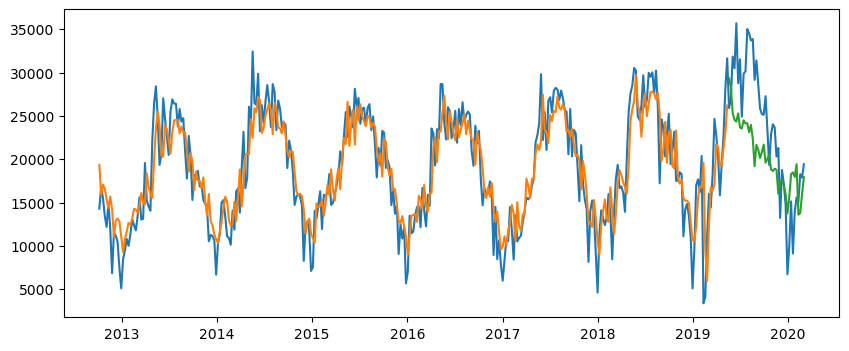

In [375]:
plt.figure(figsize=(10, 4))
plt.plot(df['Total'])
plt.plot(train_pred)
plt.plot(test_pred)
plt.show()

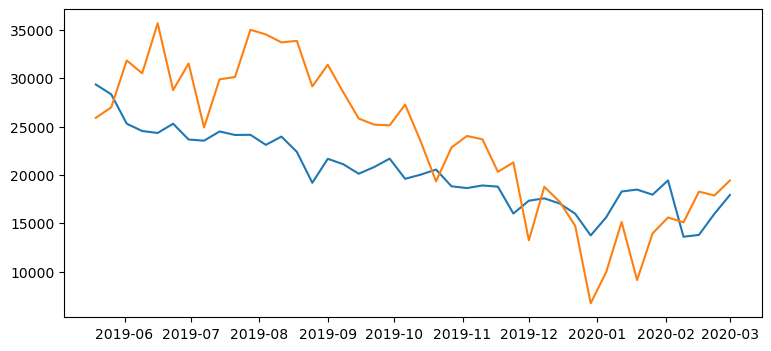

In [376]:
plt.figure(figsize=(9, 4))
plt.plot(test_pred)
plt.plot(test);

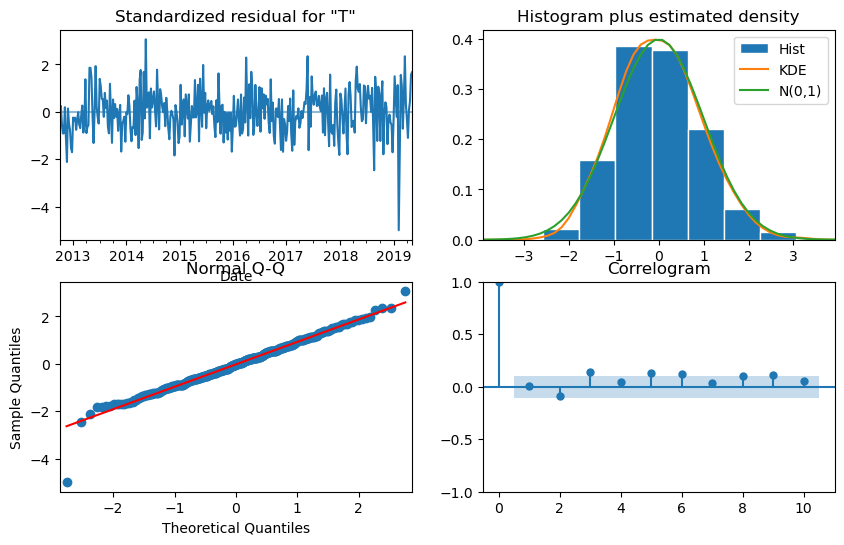

In [377]:
results.plot_diagnostics(figsize=(10, 6))
plt.show()

# BruteForce

In [381]:
from itertools import product
import statsmodels.api as sm

In [393]:
p_values = range(0, 3)  # AR order
d_values = [0]          # I order
q_values = range(0, 3)  # MA order
P_values = range(0, 2)  # Seasonal AR order
D_values = range(0, 2)  # Seasonal I order
Q_values = range(0, 2)  # Seasonal MA order
s_values = [52]         # Seasonal period 


param_combinations = list(product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))


best_params = None
best_rmse = np.inf


for params in param_combinations:
    p, d, q, P, D, Q, s = params

    # Fit the SARIMA model
    model = sm.tsa.SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
    results = model.fit()

    # Make predictions
    y_pred = results.forecast(test.shape[0])

    # Calculate RMSE (you can use other evaluation metrics if needed)
    rmse = np.sqrt(mean_squared_error(test, y_pred))

    # Update best parameters and RMSE if the current combination is better
    if rmse < best_rmse:
        best_params = params
        best_rmse = rmse


best_p, best_d, best_q, best_P, best_D, best_Q, best_s = best_params
best_params

(2, 0, 2, 1, 0, 1, 52)

In [627]:
final_model = sm.tsa.SARIMAX(train, order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, best_s))
results = final_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Total   No. Observations:                  345
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -3251.790
Date:                              Thu, 20 Jul 2023   AIC                           6517.579
Time:                                      09:39:03   BIC                           6544.484
Sample:                                  10-07-2012   HQIC                          6528.294
                                       - 05-12-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4189      0.219      1.916      0.055      -0.010       0.847
ar.L2          0.5787      0.218      2.653      0.008       0.151       1.006
ma.L1          0.0114      0.209      0.055      0.956      -0.397       0.420
ma.L2         -0.5121      0.127     -4.037      0.000      -0.761      -0.263
ar.S.L52       0.9226      0.049     18.680      0.000       0.826       1.019
ma.S.L52      -0.6369      0.123     -5.177      0.000      -0.878      -0.396
sigma2      8.601e+06   1.41e-08    6.1e+14      0.000     8.6e+06     8.6e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):                71.51
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -0.08
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+31. Standard errors may be unstable.
"""

In [395]:
train_pred = results.predict(start=train.index[0], end=train.index[-1])
test_pred = results.forecast(test.shape[0])

print('RMSE - Train: ', np.sqrt(mean_squared_error(train, train_pred)))
print('RMSE - Test: ', np.sqrt(mean_squared_error(test, test_pred)))

RMSE - Train:  3062.80749116174
RMSE - Test:  4114.980049576613


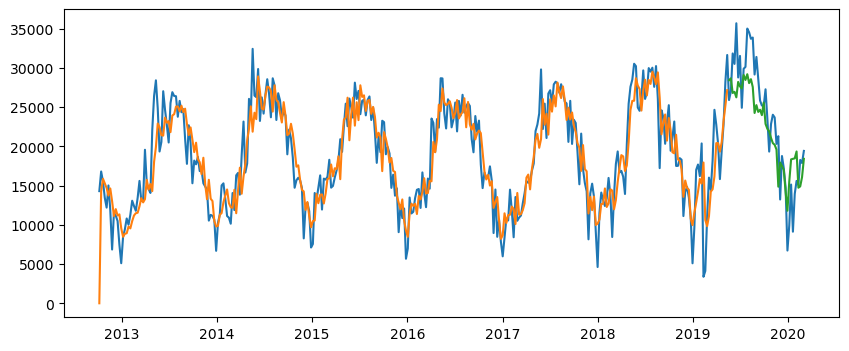

In [396]:
plt.figure(figsize=(10, 4))
plt.plot(df['Total'])
plt.plot(train_pred)
plt.plot(test_pred)
plt.show()

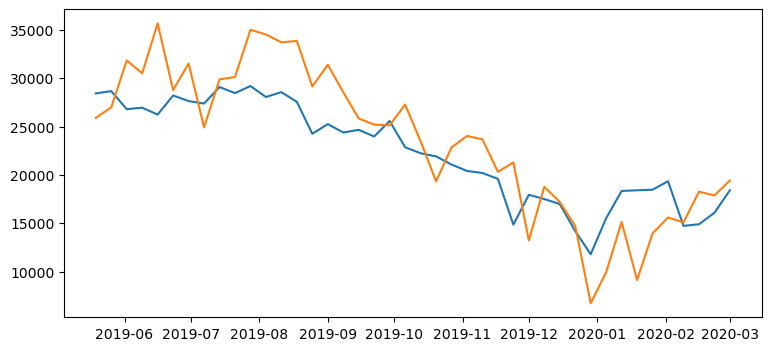

In [397]:
plt.figure(figsize=(9, 4))
plt.plot(test_pred)
plt.plot(test);

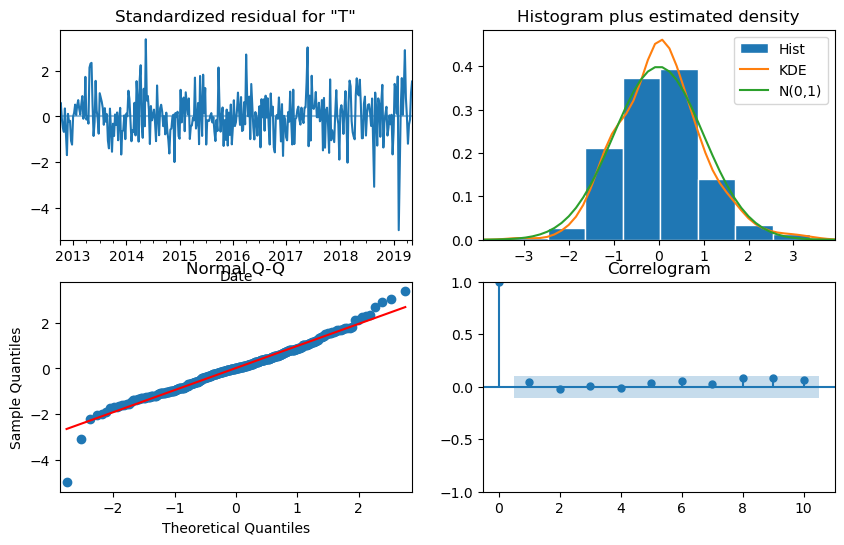

In [398]:
results.plot_diagnostics(figsize=(10, 6))
plt.show()

# AutoArima

In [399]:
from pmdarima import auto_arima

In [400]:
res = auto_arima(train,
    start_p=0,  d=None,     start_q=0,
    max_p=2,    max_d=2,    max_q=2,
    start_P=0,  D=None,     start_Q=0,
    max_P=2,    max_D=2,    max_Q=2,
    max_order=5, m=52, seasonal=True, trace=True, stepwise=True, random_state=42)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=7028.156, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=6557.845, Time=0.73 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=6693.612, Time=1.44 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=7801.604, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=6577.755, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=3.91 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=6554.718, Time=1.15 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=6565.843, Time=0.52 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=6548.654, Time=6.57 sec
 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=20.35 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=6549.107, Time=6.38 sec
 ARIMA(0,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=16.89 sec
 ARIMA(2,0,0)(2,0,1)[52] intercept   : AIC=6539.352, Time=7.63 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=6544.042, Time=1.81 sec
 ARIMA(2,0,0)(2,0,0)[52] interce

In [402]:
model = SARIMAX(train, order=(2,0,2), seasonal_order=(2,0,0,52), trend='c', )
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Total   No. Observations:                  345
Model:             SARIMAX(2, 0, 2)x(2, 0, [], 52)   Log Likelihood               -3252.402
Date:                             Wed, 19 Jul 2023   AIC                           6520.804
Time:                                     22:16:56   BIC                           6551.552
Sample:                                 10-07-2012   HQIC                          6533.049
                                      - 05-12-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1718.1153    845.820      2.031      0.042      60.339    3375.891
ar.L1          0.2470      0.254      0.973      0.331      -0.251       0.744
ar.L2          0.5597      0.201      2.789      0.005       0.166       0.953
ma.L1          0.2837      0.247      1.147      0.252      -0.201       0.769
ma.L2         -0.3745      0.095     -3.962      0.000      -0.560      -0.189
ar.S.L52       0.3024      0.076      3.970      0.000       0.153       0.452
ar.S.L104      0.2367      0.080      2.963      0.003       0.080       0.393
sigma2      1.035e+07      0.021   4.99e+08      0.000    1.03e+07    1.03e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                46.82
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.14
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.16e+24. Standard errors may be unstable.
"""

In [403]:
train_pred = results.predict(start=train.index[0], end=train.index[-1])
test_pred = results.forecast(test.shape[0])

print('RMSE - Train: ', np.sqrt(mean_squared_error(train, train_pred)))
print('RMSE - Test: ', np.sqrt(mean_squared_error(test, test_pred)))

RMSE - Train:  2980.345200863999
RMSE - Test:  5339.765448517447


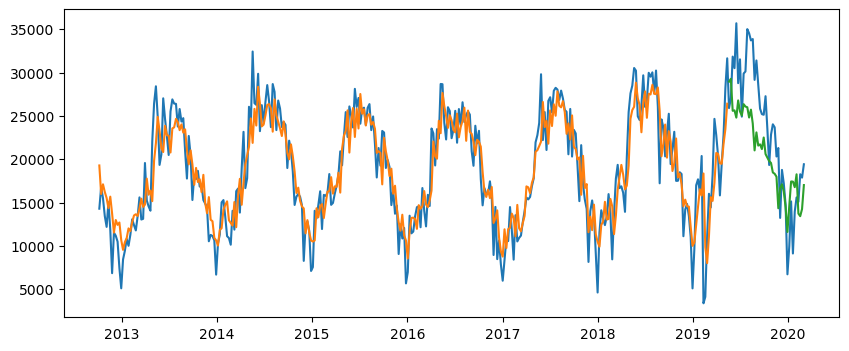

In [405]:
plt.figure(figsize=(10, 4))
plt.plot(df['Total'])
plt.plot(train_pred)
plt.plot(test_pred)
plt.show()

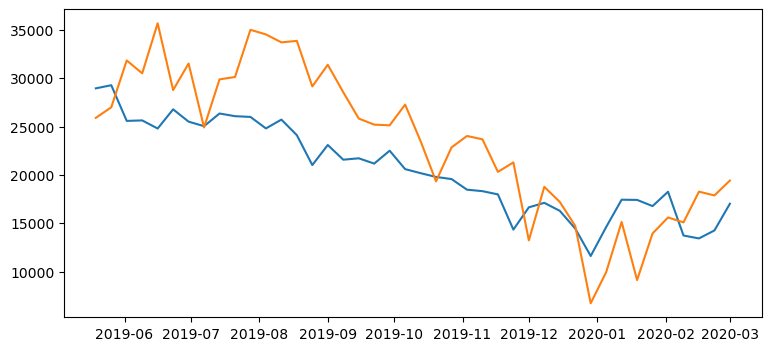

In [406]:
plt.figure(figsize=(9, 4))
plt.plot(test_pred)
plt.plot(test);

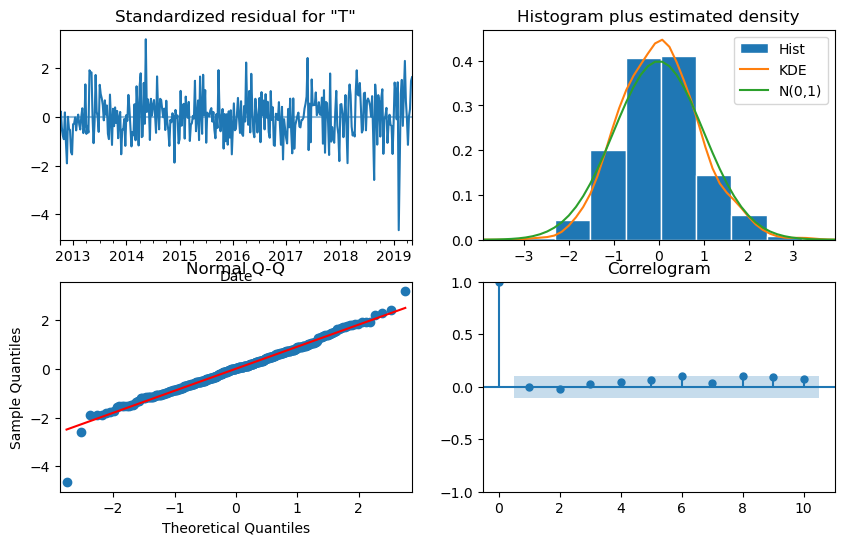

In [407]:
results.plot_diagnostics(figsize=(10, 6))
plt.show()

# Model Evaluation & Analysis

In [629]:
pd.DataFrame({'Indicators':['RMSE Train', 'RMSE Test','AIC', 'BIC','Jarque-Bera(JB)','Prob(JB)','Ljung-Box(Q)','Prob(Q)','Heteroskedasticity:'],
              'Base (1,0,1)(1,0,1)':[3116, 6130, 6543, 6566, 41.9, 0.00, 0.04, 0.84, 1.42],
              'BruteForce (2,0,2)(1,0,1)':[3062, 4114, 6517, 6544, 71.5, 0.00, 0.75, 0.39, 1.54],
              'Auto (2,0,2)(2,0,0)':[2980,5339, 6520, 6551, 46.82, 0.00, 0.01, 0.92, 1.48],
             })

,Indicators,"Base (1,0,1)(1,0,1)","BruteForce (2,0,2)(1,0,1)","Auto (2,0,2)(2,0,0)"
0,RMSE Train,3116.00,3062.00,2980.00
1,RMSE Test,6130.00,4114.00,5339.00
2,AIC,6543.00,6517.00,6520.00
3,BIC,6566.00,6544.00,6551.00
4,Jarque-Bera(JB),41.90,71.50,46.82
5,Prob(JB),0.00,0.00,0.00
6,Ljung-Box(Q),0.04,0.75,0.01
7,Prob(Q),0.84,0.39,0.92
8,Heteroskedasticity:,1.42,1.54,1.48


#### Root Mean Squared Error (RMSE) for Train and Test Data:

The BruteForce model (2,0,2)(1,0,1) has the second lowest RMSE for the train data (RMSE Train = 3062.00) and the lowest RMSE for test data (RMSE Test = 4114.00).
The Auto model (2,0,2)(2,0,0) has the lowest RMSE for the train data (RMSE Train = 2980.00) and the second lowest RMSE for the test data (RMSE Test = 5339.00).
The Base model (1,0,1)(1,0,1) has the highest RMSE for both the train data (RMSE Train = 3116.00) and the test data (RMSE Test = 6130.00).

#### Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC):

#### Jarque-Bera Test

#### Ljung-Box Test

# Conclusion